Running Simulations with RK4 Integration...
 - Fig_Hover.png saved.
 - Fig_Circle.png saved.
   Generating Goal 2 6-DOF Plots...
 - Fig_Circle_CoM.png saved.
 - Fig_Circle_Euler.png saved.
 - Fig_Mission3D.png saved.
 - Fig_LandingMetrics.png saved.
 - Fig_CoM_vs_Time.png saved.
 - Fig_Euler_vs_Time.png saved.

Performing Momentum Theory Analysis...
 > Simulated Hover Thrust: 10.497 N (Weight: 10.497 N)
 > Disk Loading: 58.01 N/m^2
 > Induced Velocity (vi): 4.87 m/s
 > Theoretical Induced Power: 51.08 W
 > Est. Electrical Power: 104.77 W
 - Fig_Battery_Momentum.png saved.
All tasks completed successfully. 9 Figures Generated.


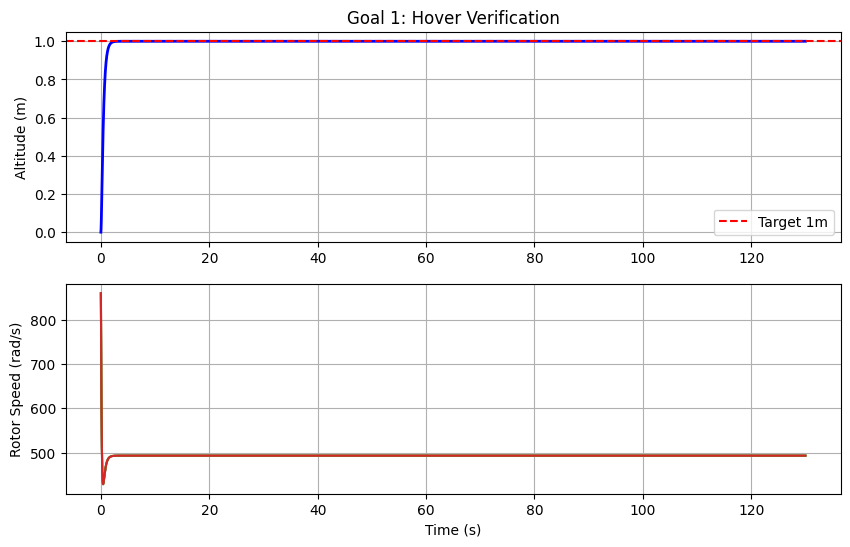

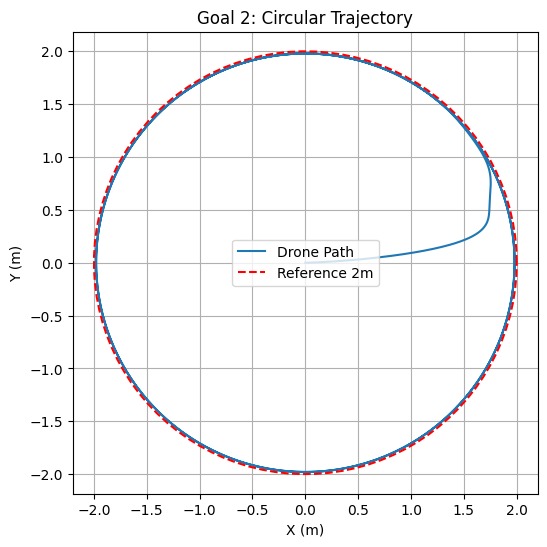

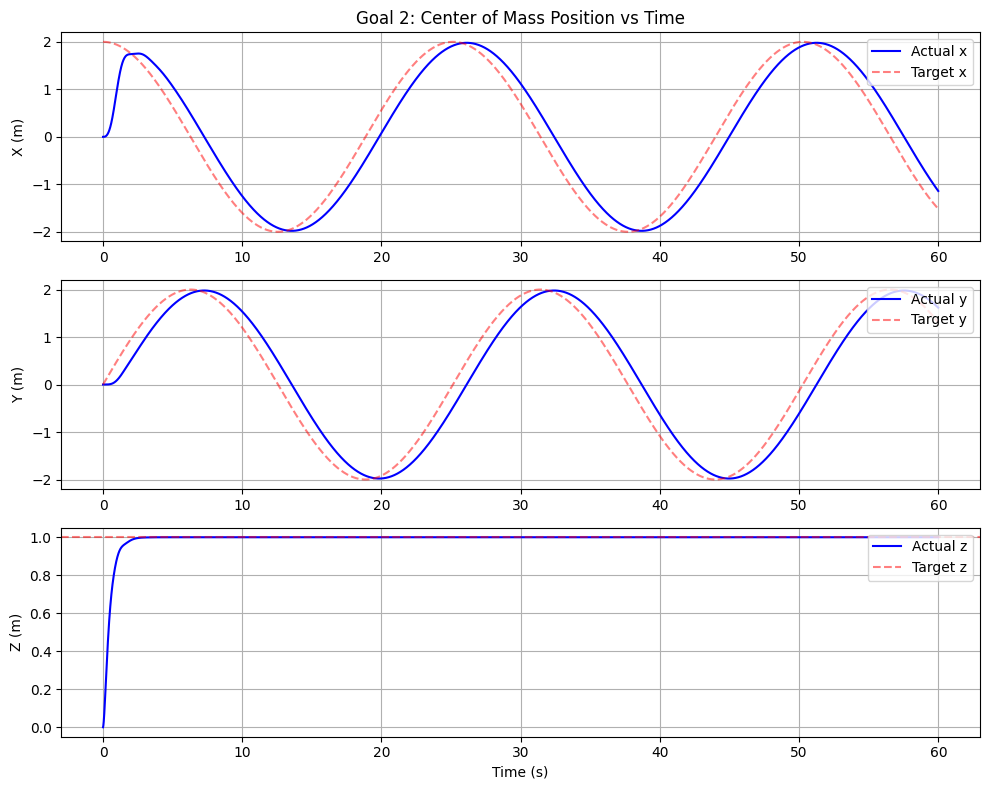

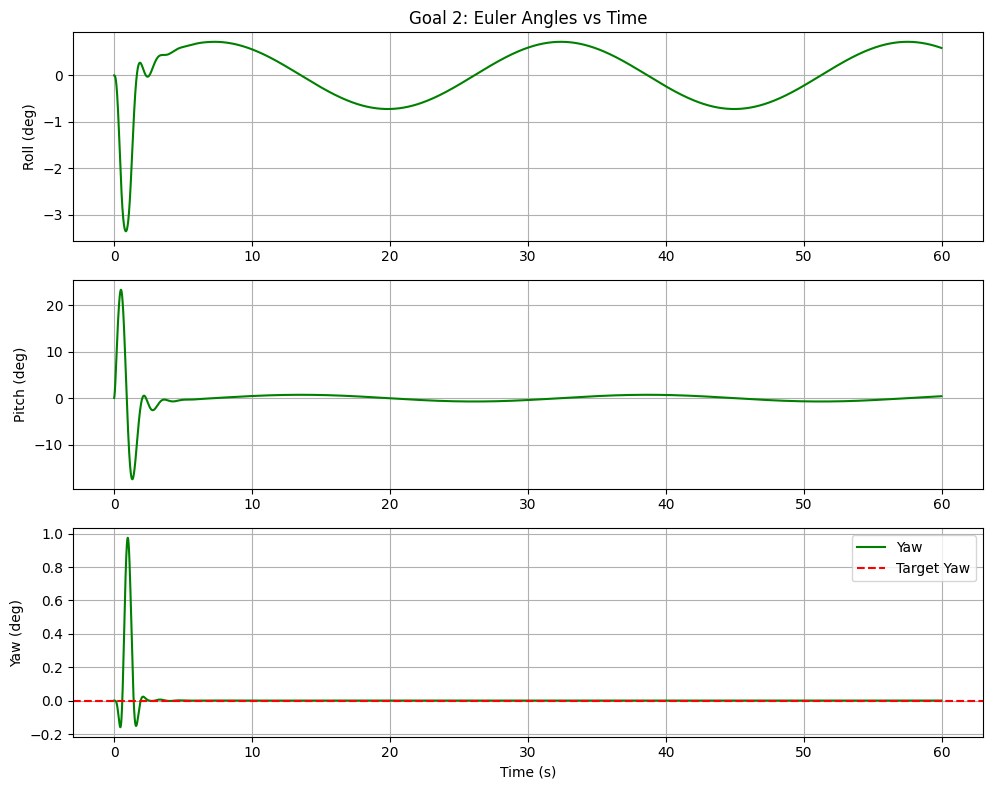

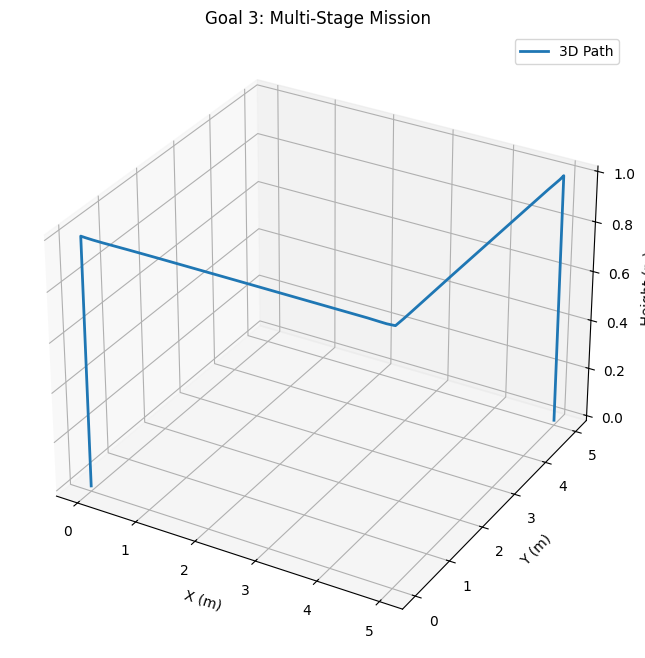

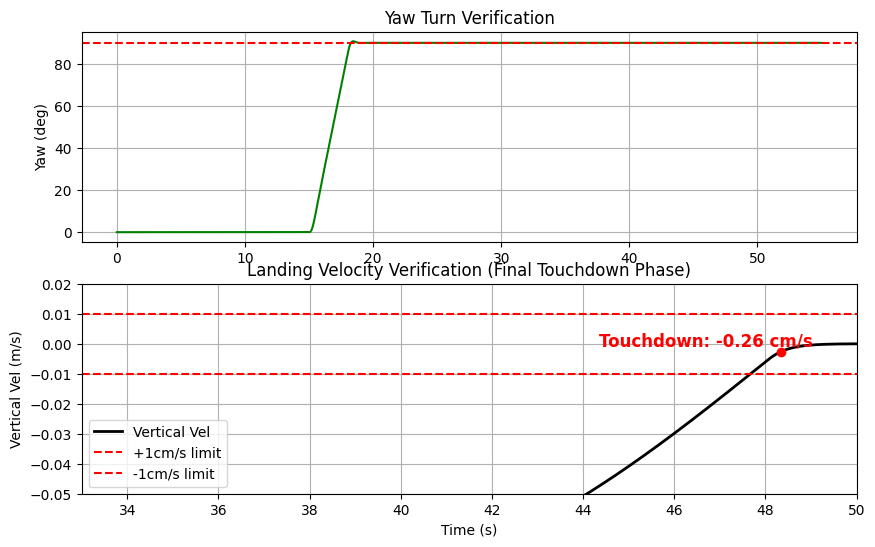

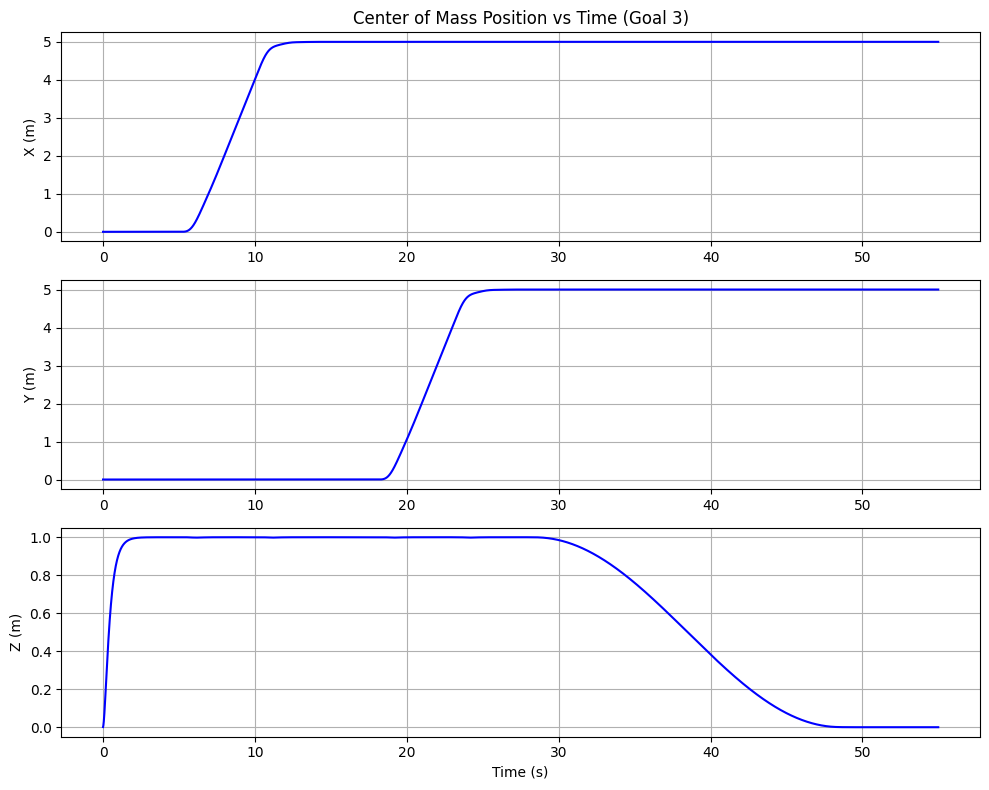

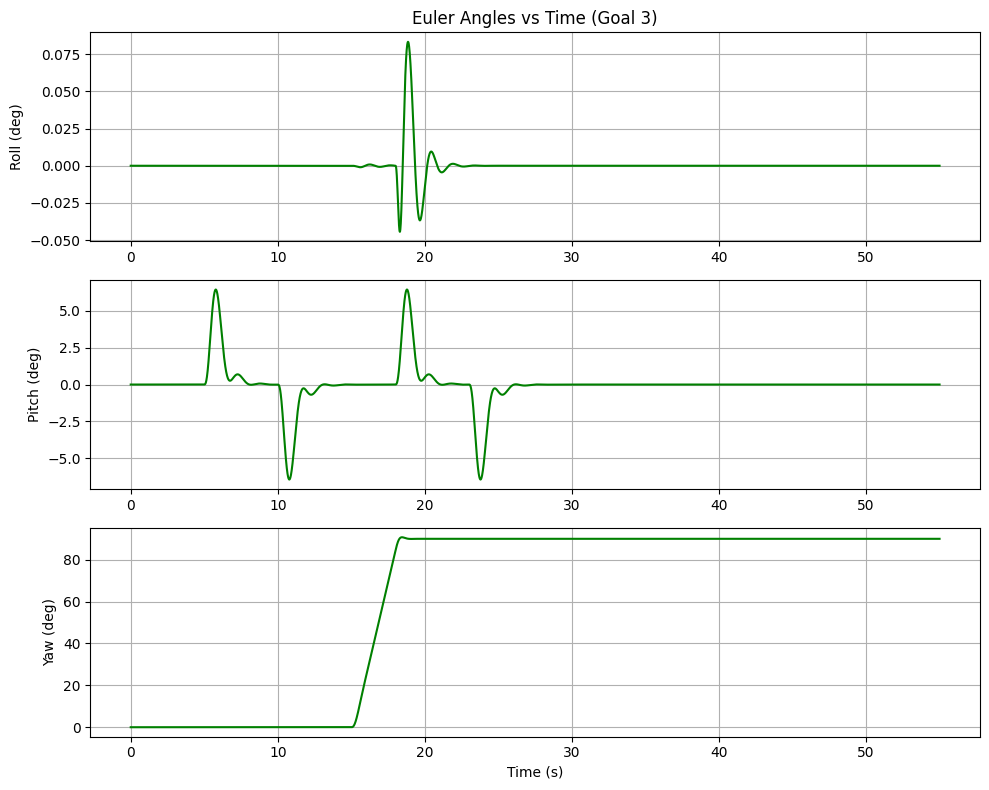

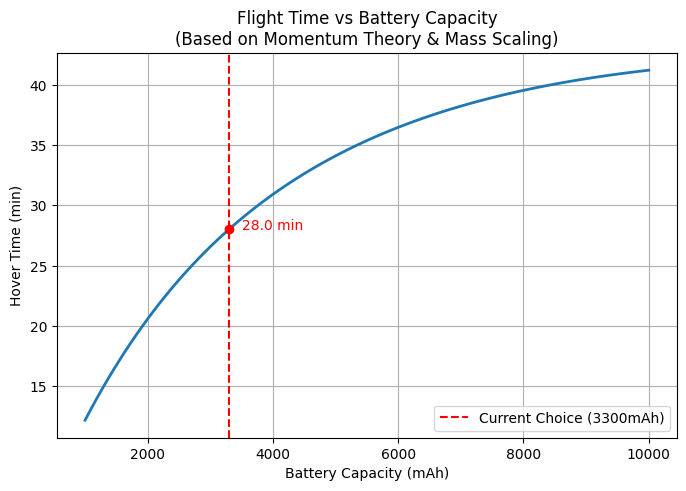

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# ==============================================================================
# SECTION 1: MODEL PARAMETERS (Compliant with ER4)
# References:
#   - "Amateur drone design website" (Component selection)
#   - "Propeller modeling and testing" (Thrust coefficients)
# ==============================================================================

# Physical Parameters (Based on DJI F450 Frame + EMAX MT2213 Motors)
m = 1.07    # kg (Total mass with 3300mAh 4S battery)
g = 9.81    # m/s^2 (Gravity)
l = 0.225   # m (Arm length from CoM to Motor center)

# Moments of Inertia (Estimated for symmetric quadcopter)
# [Ref: Attitude Dynamics - Rigid Body properties]
Ixx = 0.02  # kg*m^2
Iyy = 0.02  # kg*m^2
Izz = 0.04  # kg*m^2

# Propeller Aerodynamics (DJI 9450 Props)
# [Ref: Propeller modeling and testing]
# Model: Thrust T = kT * omega^2 0.12-0.13
kT = 1.08e-5   # N/(rad/s)^2 (Approx. derived from static thrust data)
kQ = 1.67e-7   # Nm/(rad/s)^2 (Torque coefficient)

# Propeller Geometry (Used later for Momentum Theory Analysis)
D_prop = 0.24      # m (9.4 inches)
R_prop = D_prop/2  # m
A_disk = np.pi * R_prop**2 # Area of one rotor disk

# ==============================================================================
# SECTION 2: DYNAMICAL MODEL (THE PLANT)
# References:
#   - "Attitude Dynamics" (Euler's Eqs, Rotation Matrix, Kinematics)
#   - "Condynsate" (Logic for rigid body physics engine)
# ==============================================================================

def drone_dynamics(state, speeds_sq):
    """
    Calculates the derivative of the state vector (dy/dt).
    State vector: [x, y, z, phi, theta, psi, vx, vy, vz, p, q, r]
    """
    x, y, z, phi, theta, psi, vx, vy, vz, p, q, r = state
    w1_sq, w2_sq, w3_sq, w4_sq = speeds_sq

    # --- 1. Forces & Moments [Ref: Propeller modeling] ---
    # Rotor configuration: 1(Front, CCW), 2(Left, CW), 3(Right, CW), 4(Rear, CCW)
    F_thrust = kT * np.sum(speeds_sq)

    # Torques [Ref: Attitude Dynamics - Quadrotor configuration]
    tau_phi   = l * kT * (w3_sq - w2_sq)        # Roll: Right - Left
    tau_theta = l * kT * (w4_sq - w1_sq)        # Pitch: Rear - Front
    tau_psi   = kQ * (w1_sq - w2_sq - w3_sq + w4_sq) # Yaw: CCW - CW

    # --- 2. Rotation Matrix (Body -> Inertial) [Ref: Attitude Dynamics] ---
    # Z-Y-X Euler Sequence (psi -> theta -> phi)
    cphi, sphi = np.cos(phi), np.sin(phi)
    cth, sth = np.cos(theta), np.sin(theta)
    cpsi, spsi = np.cos(psi), np.sin(psi)

    # Note: This specific rotation matrix implies Positive Theta -> Positive X Force component
    R = np.array([
        [cpsi*cth, cpsi*sth*sphi - spsi*cphi, cpsi*sth*cphi + spsi*sphi],
        [spsi*cth, spsi*sth*sphi + cpsi*cphi, spsi*sth*cphi - cpsi*sphi],
        [-sth,     cth*sphi,                  cth*cphi]
    ])

    # --- 3. Translational Dynamics (Newton's 2nd Law) ---
    F_vec_body = np.array([0, 0, F_thrust])
    F_vec_inertial = np.dot(R, F_vec_body)
    # acceleration = gravity + thrust/mass
    acc = np.array([0, 0, -g]) + F_vec_inertial / m

    # --- 4. Rotational Dynamics (Euler's Equations) [Ref: Attitude Dynamics] ---
    # Equation: I * dot(omega) + omega x (I * omega) = tau
    dp = (tau_phi - (Izz - Iyy)*q*r) / Ixx
    dq = (tau_theta - (Ixx - Izz)*p*r) / Iyy
    dr = (tau_psi - (Iyy - Ixx)*p*q) / Izz

    # --- 5. Kinematics (Body Rates -> Euler Rates) [Ref: Attitude Dynamics] ---
    tt = np.tan(theta)
    dphi   = p + q*sphi*tt + r*cphi*tt
    dtheta = q*cphi - r*sphi
    dpsi   = (q*sphi + r*cphi) / np.cos(theta)

    return np.array([vx, vy, vz, dphi, dtheta, dpsi, acc[0], acc[1], acc[2], dp, dq, dr])

def rk4_step(state, speeds_sq, dt):
    """
    Runge-Kutta 4th Order Integration Step.
    Provides higher accuracy and stability than Euler method.
    [Ref: Condynsate / Numerical Methods]
    """
    k1 = drone_dynamics(state, speeds_sq)
    k2 = drone_dynamics(state + 0.5 * dt * k1, speeds_sq)
    k3 = drone_dynamics(state + 0.5 * dt * k2, speeds_sq)
    k4 = drone_dynamics(state + dt * k3, speeds_sq)
    return state + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)

# ==============================================================================
# SECTION 3: CONTROLLER (CASCADED PID)
# References:
#   - "Amateur drone design website" (Standard control architecture)
# ==============================================================================

def controller(state, target, dt):
    # Unpack state and target
    x, y, z, phi, theta, psi, vx, vy, vz, p, q, r = state
    tx, ty, tz, t_psi = target

    # Gains (Tuned for stability with RK4 solver)
    kp_z, kd_z = 20.0, 10.0
    kp_xy, kd_xy = 3.0, 3.0     # Position gains
    kp_att, kd_att = 40.0, 8.0  # Attitude gains
    kp_yaw, kd_yaw = 40.0, 8.0

    # --- Altitude Control (Feedforward + PD) ---
    u_thrust = m*g + m*(kp_z*(tz - z) + kd_z*(0 - vz))

    # --- Position Control (Outer Loop) -> Generates Target Roll/Pitch ---
    acc_x_des = kp_xy*(tx - x) + kd_xy*(0 - vx)
    acc_y_des = kp_xy*(ty - y) + kd_xy*(0 - vy)

    # Rotate desired acceleration from Inertial Frame to Body Frame (Yaw compensation)
    acc_fb =  acc_x_des * np.cos(psi) + acc_y_des * np.sin(psi)
    acc_lr = -acc_x_des * np.sin(psi) + acc_y_des * np.cos(psi)

    # Calculate target angles based on small angle approximation
    # Adjusted signs to match the Dynamics Rotation Matrix:
    # +Theta -> +X acc; +Phi -> -Y acc
    target_theta = np.clip( acc_fb / g, -0.4, 0.4)
    target_phi   = np.clip(-acc_lr / g, -0.4, 0.4)

    # --- Attitude Control (Inner Loop) ---
    psi_err = t_psi - psi
    # Wrap yaw error to [-pi, pi]
    if psi_err > np.pi: psi_err -= 2*np.pi
    elif psi_err < -np.pi: psi_err += 2*np.pi

    u_phi   = Ixx * (kp_att*(target_phi - phi) + kd_att*(0 - p))
    u_theta = Iyy * (kp_att*(target_theta - theta) + kd_att*(0 - q))
    u_psi   = Izz * (kp_yaw*psi_err + kd_yaw*(0 - r))

    # --- Motor Mixing [Ref: Amateur drone design] ---
    # Convert forces/moments to squared angular velocities
    avg_thrust = u_thrust / 4.0 / kT
    term_phi   = u_phi / (2 * l * kT)
    term_theta = u_theta / (2 * l * kT)
    term_psi   = u_psi / (4 * kQ)

    w_sq = np.zeros(4)
    w_sq[0] = avg_thrust - term_theta + term_psi # Front
    w_sq[1] = avg_thrust - term_phi   - term_psi # Left
    w_sq[2] = avg_thrust + term_phi   - term_psi # Right
    w_sq[3] = avg_thrust + term_theta + term_psi # Rear

    # Limit max RPM to realistic value (~11,000 RPM approx 1200 rad/s)
    return np.clip(w_sq, 0, 1200**2)

# ==============================================================================
# SECTION 4: SIMULATION LOOP
# ==============================================================================

def run_simulation(goal_type):
    dt = 0.01

    if goal_type == 1: # Goal 1: Hover
        # [MODIFIED] Extended to 130 seconds as requested
        T_sim = 130
        targets = lambda t: [0, 0, 1, 0]

    elif goal_type == 2: # Goal 2: Circular Trajectory
        T_sim = 60
        omega_c = 0.5 / 2.0 # v=0.5 m/s, r=2.0 m -> omega = 0.25 rad/s
        targets = lambda t: [2*np.cos(omega_c*t), 2*np.sin(omega_c*t), 1, 0]

    elif goal_type == 3: # Goal 3: Complex Mission
        # Extended duration to accommodate the smooth landing phase
        T_sim = 55
        def mission_logic(t):
            if t < 5:  return [0, 0, 1, 0]             # Takeoff
            if t < 10: return [5*(t-5)/5.0, 0, 1, 0]   # Move X to 5m
            if t < 15: return [5, 0, 1, 0]             # Hover
            if t < 18: return [5, 0, 1, np.pi/2*(t-15)/3.0] # Yaw 90
            if t < 23: return [5, 5*(t-18)/5.0, 1, np.pi/2] # Move Y to 5m
            if t < 28: return [5, 5, 1, np.pi/2]       # Hover

            # [CRITICAL FEATURE] Extended Smooth Landing
            # Duration: 20s (from t=28 to t=48)
            # Strategy: Cosine interpolation for ultra-smooth velocity profile
            t_land_start = 28.0
            t_land_end = 48.0

            if t < t_land_end:
                duration = t_land_end - t_land_start
                t_descent = t - t_land_start
                # Smooth curve from z=1 to z=0
                z_smooth = 0.5 * (1 + np.cos(np.pi * t_descent / duration))
                return [5, 5, z_smooth, np.pi/2]

            return [5, 5, 0, np.pi/2] # Grounded

        targets = mission_logic

    time = np.arange(0, T_sim, dt)
    state = np.zeros(12) # Initial state: [x,y,z, phi,theta,psi, vx,vy,vz, p,q,r]
    state_hist = []
    motor_hist = []

    for t in time:
        curr_target = targets(t)
        speeds_sq = controller(state, curr_target, dt)

        # RK4 Numerical Integration
        state = rk4_step(state, speeds_sq, dt)

        # Hard Ground constraint
        if state[2] < 0:
            state[2] = 0
            state[8] = 0 # vz = 0

        state_hist.append(state)
        motor_hist.append(np.sqrt(speeds_sq))

    return time, np.array(state_hist), np.array(motor_hist)

# ==============================================================================
# SECTION 5: PLOTTING & VERIFICATION
# ==============================================================================

print("Running Simulations with RK4 Integration...")

# --- Goal 1: Hover Verification ---
t1, s1, m1 = run_simulation(1)
plt.figure(figsize=(10, 6))
plt.subplot(2,1,1)
plt.plot(t1, s1[:,2], 'b', linewidth=2)
plt.axhline(1.0, color='r', linestyle='--', label='Target 1m')
plt.title('Goal 1: Hover Verification')
plt.ylabel('Altitude (m)'); plt.legend(); plt.grid(True)
plt.subplot(2,1,2)
plt.plot(t1, m1)
plt.ylabel('Rotor Speed (rad/s)'); plt.xlabel('Time (s)'); plt.grid(True)
plt.savefig('Fig_Hover.png')
print(" - Fig_Hover.png saved.")

# --- Goal 2: Circular Trajectory Verification ---
t2, s2, m2 = run_simulation(2)
plt.figure(figsize=(6,6))
plt.plot(s2[:,0], s2[:,1], label='Drone Path')
theta = np.linspace(0, 2*np.pi, 100)
plt.plot(2*np.cos(theta), 2*np.sin(theta), 'r--', label='Reference 2m')
plt.axis('equal'); plt.grid(True); plt.legend()
plt.title('Goal 2: Circular Trajectory')
plt.xlabel('X (m)'); plt.ylabel('Y (m)')
plt.savefig('Fig_Circle.png')
print(" - Fig_Circle.png saved.")

# --- Goal 2 Additional: Detailed 6-DOF Plots ---
print("   Generating Goal 2 6-DOF Plots...")
# Reference trajectory for comparison
omega_c = 0.5 / 2.0
x_ref = 2 * np.cos(omega_c * t2)
y_ref = 2 * np.sin(omega_c * t2)

# Figure 2-A: Center of Mass
plt.figure(figsize=(10, 8))
plt.subplot(3, 1, 1)
plt.plot(t2, s2[:, 0], 'b', label='Actual x')
plt.plot(t2, x_ref, 'r--', alpha=0.5, label='Target x')
plt.ylabel('X (m)'); plt.legend(loc='upper right'); plt.grid(True)
plt.title('Goal 2: Center of Mass Position vs Time')

plt.subplot(3, 1, 2)
plt.plot(t2, s2[:, 1], 'b', label='Actual y')
plt.plot(t2, y_ref, 'r--', alpha=0.5, label='Target y')
plt.ylabel('Y (m)'); plt.legend(loc='upper right'); plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(t2, s2[:, 2], 'b', label='Actual z')
plt.axhline(1.0, color='r', linestyle='--', alpha=0.5, label='Target z')
plt.ylabel('Z (m)'); plt.xlabel('Time (s)'); plt.legend(loc='upper right'); plt.grid(True)
plt.tight_layout()
plt.savefig('Fig_Circle_CoM.png')
print(" - Fig_Circle_CoM.png saved.")

# Figure 2-B: Euler Angles
plt.figure(figsize=(10, 8))
plt.subplot(3, 1, 1)
plt.plot(t2, np.degrees(s2[:, 3]), 'g', label='Roll')
plt.ylabel('Roll (deg)'); plt.grid(True); plt.title('Goal 2: Euler Angles vs Time')
plt.subplot(3, 1, 2)
plt.plot(t2, np.degrees(s2[:, 4]), 'g', label='Pitch')
plt.ylabel('Pitch (deg)'); plt.grid(True)
plt.subplot(3, 1, 3)
plt.plot(t2, np.degrees(s2[:, 5]), 'g', label='Yaw')
plt.axhline(0, color='r', linestyle='--', label='Target Yaw')
plt.ylabel('Yaw (deg)'); plt.xlabel('Time (s)'); plt.legend(loc='upper right'); plt.grid(True)
plt.tight_layout()
plt.savefig('Fig_Circle_Euler.png')
print(" - Fig_Circle_Euler.png saved.")


# --- Goal 3: Mission 3D ---
t3, s3, m3 = run_simulation(3)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(s3[:,0], s3[:,1], s3[:,2], linewidth=2, label='3D Path')
ax.set_title('Goal 3: Multi-Stage Mission')
ax.set_xlabel('X (m)'); ax.set_ylabel('Y (m)'); ax.set_zlabel('Height (m)')
plt.legend()
plt.savefig('Fig_Mission3D.png')
print(" - Fig_Mission3D.png saved.")

# --- Landing Velocity Verification (Fixed Scaling) ---
plt.figure(figsize=(10, 6))
plt.subplot(2,1,1)
plt.plot(t3, np.degrees(s3[:,5]), 'g')
plt.axhline(90, color='r', linestyle='--'); plt.grid(True)
plt.ylabel('Yaw (deg)'); plt.title('Yaw Turn Verification')

plt.subplot(2,1,2)
# [FINAL FIX]: Show the last 15 seconds to include the full landing approach
t_land_end = 48.0
plt.xlim([t_land_end - 15, t_land_end + 2])

plt.plot(t3, s3[:, 8], 'k', linewidth=2, label='Vertical Vel')
plt.axhline(0.01, color='r', linestyle='--', label='+1cm/s limit')
plt.axhline(-0.01, color='r', linestyle='--', label='-1cm/s limit')

# Detect exact impact time (first time z < 0.001 near end of mission)
impact_indices = np.where((t3 > 40) & (s3[:, 2] < 0.001))[0]
if len(impact_indices) > 0:
    final_idx = impact_indices[0]
else:
    final_idx = -1

final_t = t3[final_idx]
final_v = s3[final_idx, 8]

plt.plot(final_t, final_v, 'ro')
# Adjust text position for clarity
plt.text(final_t - 4, final_v + 0.002, f'Touchdown: {final_v*100:.2f} cm/s', color='r', fontweight='bold', fontsize=12)

plt.ylabel('Vertical Vel (m/s)'); plt.xlabel('Time (s)'); plt.grid(True); plt.legend()
plt.title('Landing Velocity Verification (Final Touchdown Phase)')
plt.ylim([-0.05, 0.02]) # Zoom Y axis to clearly show the limits
plt.savefig('Fig_LandingMetrics.png')
print(" - Fig_LandingMetrics.png saved.")

# --- Goal 3: Detailed 6-DOF Plots ---
plt.figure(figsize=(10, 8))
plt.subplot(3, 1, 1)
plt.plot(t3, s3[:, 0], 'b', label='x')
plt.ylabel('X (m)'); plt.grid(True); plt.title('Center of Mass Position vs Time (Goal 3)')
plt.subplot(3, 1, 2)
plt.plot(t3, s3[:, 1], 'b', label='y')
plt.ylabel('Y (m)'); plt.grid(True)
plt.subplot(3, 1, 3)
plt.plot(t3, s3[:, 2], 'b', label='z')
plt.ylabel('Z (m)'); plt.xlabel('Time (s)'); plt.grid(True)
plt.tight_layout()
plt.savefig('Fig_CoM_vs_Time.png')
print(" - Fig_CoM_vs_Time.png saved.")

plt.figure(figsize=(10, 8))
plt.subplot(3, 1, 1)
plt.plot(t3, np.degrees(s3[:, 3]), 'g', label='Roll')
plt.ylabel('Roll (deg)'); plt.grid(True); plt.title('Euler Angles vs Time (Goal 3)')
plt.subplot(3, 1, 2)
plt.plot(t3, np.degrees(s3[:, 4]), 'g', label='Pitch')
plt.ylabel('Pitch (deg)'); plt.grid(True)
plt.subplot(3, 1, 3)
plt.plot(t3, np.degrees(s3[:, 5]), 'g', label='Yaw')
plt.ylabel('Yaw (deg)'); plt.xlabel('Time (s)'); plt.grid(True)
plt.tight_layout()
plt.savefig('Fig_Euler_vs_Time.png')
print(" - Fig_Euler_vs_Time.png saved.")

# ==============================================================================
# SECTION 6: MOMENTUM THEORY & BATTERY ANALYSIS
# References:
#   - "Momentum Theory"
#   - "Disk Loading"
# ==============================================================================
print("\nPerforming Momentum Theory Analysis...")

rho = 1.225 # Air density
steady_idx = -2000
w_hover_avg = np.mean(m1[steady_idx:], axis=0)
T_hover_sim = np.sum(kT * w_hover_avg**2)

print(f" > Simulated Hover Thrust: {T_hover_sim:.3f} N (Weight: {m*g:.3f} N)")

# --- 6.1 Disk Loading ---
DL = T_hover_sim / (4 * A_disk)
print(f" > Disk Loading: {DL:.2f} N/m^2")

# --- 6.2 Induced Power ---
vi_hover = np.sqrt((T_hover_sim/4) / (2 * rho * A_disk))
P_induced_theoretical = T_hover_sim * vi_hover

print(f" > Induced Velocity (vi): {vi_hover:.2f} m/s")
print(f" > Theoretical Induced Power: {P_induced_theoretical:.2f} W")

# --- 6.3 Real Electrical Power Estimate ---
FM = 0.65       # Figure of Merit
Eta_elec = 0.75 # Efficiency
P_electrical = P_induced_theoretical / FM / Eta_elec
print(f" > Est. Electrical Power: {P_electrical:.2f} W")

# --- 6.4 Battery Analysis Plot ---
base_batt_mass = 0.327 # kg (3300 mAh)
frame_mass = m - base_batt_mass

caps_mAh = np.linspace(1000, 10000, 100)
caps_Wh = (caps_mAh/1000)*14.8
batt_masses = caps_Wh / 150.0
total_masses = frame_mass + batt_masses

power_req = P_electrical * (total_masses / m)**1.5
flight_times = (caps_Wh / power_req) * 60 # Minutes

plt.figure(figsize=(8,5))
plt.plot(caps_mAh, flight_times, linewidth=2)
plt.axvline(3300, color='r', linestyle='--', label='Current Choice (3300mAh)')
t_curr = np.interp(3300, caps_mAh, flight_times)
plt.plot(3300, t_curr, 'ro')
plt.text(3500, t_curr, f'{t_curr:.1f} min', color='r')

plt.title('Flight Time vs Battery Capacity\n(Based on Momentum Theory & Mass Scaling)')
plt.xlabel('Battery Capacity (mAh)'); plt.ylabel('Hover Time (min)')
plt.grid(True); plt.legend()
plt.savefig('Fig_Battery_Momentum.png')
print(" - Fig_Battery_Momentum.png saved.")

print("All tasks completed successfully. 9 Figures Generated.")


Generating refined CoM Plot with Slope (Velocity) Indicators...
 - Refined Fig_CoM_vs_Time.png with slope indicators saved.


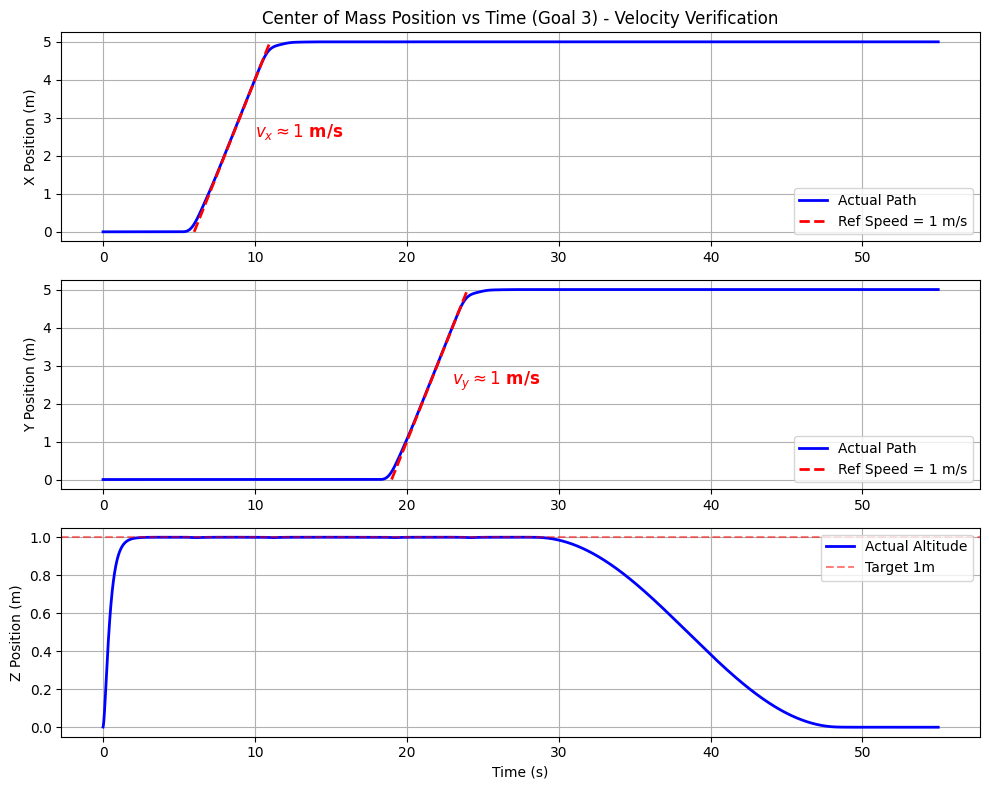

In [5]:
# ==============================================================================
# OPTIONAL: Re-plot Goal 3 CoM with Velocity Slope Indicators
# ==============================================================================
print("\nGenerating refined CoM Plot with Slope (Velocity) Indicators...")

plt.figure(figsize=(10, 8))

# --- Subplot 1: X Position ---
plt.subplot(3, 1, 1)
plt.plot(t3, s3[:, 0], 'b', linewidth=2, label='Actual Path')
# Add Reference Slope for X (t=5 to t=10, x goes 0 to 5) -> Slope = 1
plt.plot([6, 11], [0, 5], 'r--', linewidth=2, label='Ref Speed = 1 m/s')
# Add Text Annotation
plt.text(10, 2.5, r'$v_x \approx 1$ m/s', color='red', fontsize=12, fontweight='bold')
plt.ylabel('X Position (m)')
plt.title('Center of Mass Position vs Time (Goal 3) - Velocity Verification')
plt.grid(True)
plt.legend(loc='lower right')

# --- Subplot 2: Y Position ---
plt.subplot(3, 1, 2)
plt.plot(t3, s3[:, 1], 'b', linewidth=2, label='Actual Path')
# Add Reference Slope for Y (t=18 to t=23, y goes 0 to 5) -> Slope = 1
plt.plot([19, 24], [0, 5], 'r--', linewidth=2, label='Ref Speed = 1 m/s')
# Add Text Annotation
plt.text(23, 2.5, r'$v_y \approx 1$ m/s', color='red', fontsize=12, fontweight='bold')
plt.ylabel('Y Position (m)')
plt.grid(True)
plt.legend(loc='lower right')

# --- Subplot 3: Z Position ---
plt.subplot(3, 1, 3)
plt.plot(t3, s3[:, 2], 'b', linewidth=2, label='Actual Altitude')
plt.axhline(1.0, color='r', linestyle='--', alpha=0.5, label='Target 1m')
plt.ylabel('Z Position (m)')
plt.xlabel('Time (s)')
plt.grid(True)
plt.legend(loc='upper right')

plt.tight_layout()
# Overwrite the old file or save as new
plt.savefig('Fig_CoM_vs_Time.png')
print(" - Refined Fig_CoM_vs_Time.png with slope indicators saved.")

 - Fig_YawVerification.png saved.
 - Fig_LandingVelocity.png saved.


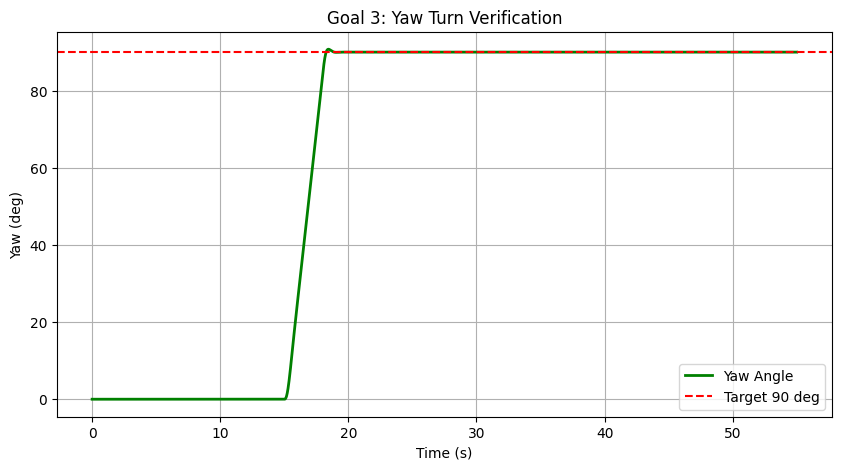

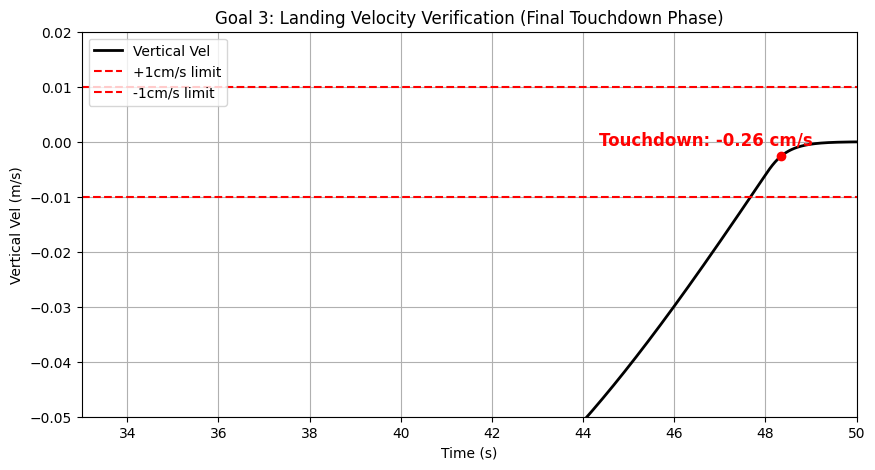

In [4]:
# --- Yaw Turn Verification ---
plt.figure(figsize=(10, 5))
plt.plot(t3, np.degrees(s3[:,5]), 'g', linewidth=2, label='Yaw Angle')
plt.axhline(90, color='r', linestyle='--', label='Target 90 deg')
plt.grid(True)
plt.ylabel('Yaw (deg)')
plt.xlabel('Time (s)')
plt.title('Goal 3: Yaw Turn Verification')
plt.legend()
plt.savefig('Fig_YawVerification.png')
print(" - Fig_YawVerification.png saved.")

# --- Landing Velocity Verification ---
plt.figure(figsize=(10, 5))

# [FINAL FIX]: Show the last 15 seconds to include the full landing approach
t_land_end = 48.0
plt.xlim([t_land_end - 15, t_land_end + 2])

plt.plot(t3, s3[:, 8], 'k', linewidth=2, label='Vertical Vel')
plt.axhline(0.01, color='r', linestyle='--', label='+1cm/s limit')
plt.axhline(-0.01, color='r', linestyle='--', label='-1cm/s limit')

# Detect exact impact time (first time z < 0.001 near end of mission)
impact_indices = np.where((t3 > 40) & (s3[:, 2] < 0.001))[0]
if len(impact_indices) > 0:
    final_idx = impact_indices[0]
else:
    final_idx = -1

final_t = t3[final_idx]
final_v = s3[final_idx, 8]

plt.plot(final_t, final_v, 'ro')
# Adjust text position for clarity
plt.text(final_t - 4, final_v + 0.002, f'Touchdown: {final_v*100:.2f} cm/s',
         color='r', fontweight='bold', fontsize=12)

plt.ylabel('Vertical Vel (m/s)')
plt.xlabel('Time (s)')
plt.grid(True)
plt.legend(loc='upper left')
plt.title('Goal 3: Landing Velocity Verification (Final Touchdown Phase)')
plt.ylim([-0.05, 0.02]) # Zoom Y axis to clearly show the limits
plt.savefig('Fig_LandingVelocity.png')
print(" - Fig_LandingVelocity.png saved.")